tconst                  object
primaryTitle            object
isAdult                  int64
startYear                int64
runtimeMinutes         float64
genres                  object
averageRating          float64
numVotes               float64
actors                  object
Budget                   int64
GrossUSA                 int64
WorldGross               int64
ReleaseDate             object
directors               object
writers                 object
director_sentiments     object
num_actors             float64
Country                 object
dtype: object

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import pickle
import matplotlib.pyplot as plt

# Read Data 

### num_cols and predic_col are fixed. 
### For string_col, we tokenize the text into numbers and treat each in string_col as a column.
### For category_col, we vectorize and tokenize based on input max_features. 
### We explore and switch cols in string_col and category_col to see how it influences the prediction.
For example, there are 32 different genres, we can change it to a length-32 vector, each entry in this vector is a binary indicator indicating if this genre is the tag for this movie.
Max_features mean how many top frequent features we want to keep in vector. 

In [2]:
string_cols = ["primaryTitle", "Country", "directors", "writers"]
category_cols = ["genres", "actors"]
num_cols = ["runtimeMinutes",  "director_sentiments","writer_sentiments", "director_sentiments_num", "writer_sentiments_num"]
predict_col = ["WorldGross"]

In [3]:
def replace_nan_data(data):
    for ch in string_cols:
        data[ch] = data[ch].fillna("others")
    for ch in category_cols:
        data[ch] = data[ch].fillna("others")
    for ch in num_cols:
        data[ch] = data[ch].fillna(0) #??
    return data

In [4]:
atemp = pd.read_csv("final_work_model_on_this_data.csv", encoding='utf-8',dtype =  {"primaryTitle":"str",
        "genres":"str","actors":"str", "ReleaseDate":"str", "writers":"str", "Country":"str"})
atemp = replace_nan_data(atemp)
atemp = atemp.sample(frac=1, random_state=5)
atemp.dtypes


Unnamed: 0                      int64
tconst                         object
primaryTitle                   object
isAdult                         int64
startYear                       int64
runtimeMinutes                float64
genres                         object
averageRating                 float64
numVotes                      float64
actors                         object
Budget                          int64
GrossUSA                        int64
WorldGross                      int64
ReleaseDate                    object
directors                      object
writers                        object
director_sentiments           float64
num_actors                    float64
director_sentiments_summed    float64
director_sentiments_num       float64
writer_sentiments             float64
writer_sentiments_summed      float64
writer_sentiments_num         float64
Country                        object
dtype: object

In [5]:
atemp.head()

,Unnamed: 0,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,...,directors,writers,director_sentiments,num_actors,director_sentiments_summed,director_sentiments_num,writer_sentiments,writer_sentiments_summed,writer_sentiments_num,Country
20143,20176,tt6985094,The Juror,0,2019,114.0,Drama,6.9,326.0,"Young-yi Lee,Hyung-shik Park,Jung-Yeon Seo",...,Seung-wan Hong,others,0.000000,3.0,NaN,0.0,0.000000,NaN,0.0,South Korea
17395,17425,tt5639784,Lucha: Playing the Impossible,0,2016,93.0,Documentary,7.1,29.0,Luciana Aymar,...,Ana Quiroga,Milagros Lay González,-0.068889,1.0,-1.033333,15.0,0.000000,NaN,0.0,Argentina
816,822,tt10443846,Yeh Saali Aashiqui,0,2019,137.0,Thriller,8.1,138.0,"Deepansha Dhingra,SahibSinghNarang,Mohan Nayya...",...,Cherag Ruparel,Vardhan Puri,0.000000,5.0,0.000000,1.0,0.452222,6.783333,15.0,India
22729,22765,tt9015188,Tailgate,0,2019,85.0,"Comedy,Horror,Thriller",6.1,213.0,"Willem de Wolf,Stacey Matla,Tine Deseure,Chris...",...,Lodewijk Crijns,Lodewijk Crijns,0.000000,9.0,NaN,0.0,0.000000,NaN,0.0,Netherlands
2008,2014,tt1235424,Ganz nah bei Dir,0,2009,88.0,"Comedy,Drama",6.7,157.0,"Armin Zarbock,Speedy Deftereos",...,Almut Getto,Speedy Deftereos,0.000000,2.0,NaN,0.0,0.000000,NaN,0.0,Germany


# Process Data With Feature Selection

In [6]:
def process_string_cols(data):
    lb_make = LabelEncoder()
    #do we need to binary to list?
    result = []
    for ch in data:
        new_data = lb_make.fit_transform(data[ch]) 
        #if prefer binarizer
        #binarizer = preprocessing.LabelBinarizer()
        #new_data = binarizer.fit_transform(new_data) 
        result.append(new_data)
    #encoded_data = lb_make.fit_transform(data) 
    #binarizer = preprocessing.LabelBinarizer()
    #return binarizer.fit_transform(encoded_data) 
    return np.array(result).transpose()
def process_category_cols(data, max_features_num = 20):
    
    result = []
    for ch in data:
        if ch == "genres":
            # it's better genres always have all token
            vectorizer = CountVectorizer()
        else:
            vectorizer = CountVectorizer(max_features = max_features_num)
        vectoried_data = vectorizer.fit_transform(data[ch])
        result.append(vectoried_data.toarray())
    #return np.array(result)
    return np.concatenate(result, axis = 1)
    #lb_make = LabelEncoder()
    #do we need to binary to list?
    #result = []
    #for ch in data:
        #new_data = lb_make.fit_transform(data[ch]) 
        #if prefer binarizer
        
        #binarizer = preprocessing.LabelBinarizer()
        #new_data = binarizer.fit_transform(new_data) 
        #result.append(new_data)
    #encoded_data = lb_make.fit_transform(data) 
    #binarizer = preprocessing.LabelBinarizer()
    #return binarizer.fit_transform(encoded_data) 
    #return np.array(result)
def process_numerical_cols(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    return min_max_scaler.fit_transform(data), min_max_scaler
def process_actors_col(data, n):
    vectorizer = CountVectorizer()
    [actors.split() for actors in data]
    freq = get_most_freq_actors(data, n)
    result = []
    for actors in data:
        entries = actors.split(',')
        entries = [ch if ch in freq else "" for ch in entries ]
        #vectoried_data = vectorizer.fit_transform(entries)
        result.append(entries)
    array =  pd.DataFrame(result)
    print(array.head())
    vectoried_data = vectorizer.fit_transform(array)
    return vectoried_data.toarray()
def get_most_freq_actors(data, n=35):
    """
    param data: Pandas dataframe
    param n: How many actors to return (Top n most frequent actors)
    """
    
    # Get list of all actors
    all_actors_list = [x.split(',') for x in data if type(x)==str]
    all_actors = []
    for i in range(len(all_actors_list)):
        all_actors += all_actors_list[i]
        
    # Use Counter(list) to get most frequent actors and counts
    actor_counter = Counter(all_actors)
    most_common = actor_counter.most_common(n)
    most_freq_actors, most_freq_actor_counts = zip(*most_common)
    
    return np.array(most_freq_actors) 

def process_tokenize_all_cols(input_data, max_feature_num=20):
    
    data_string = process_string_cols(input_data[string_cols]) 
    data_num, min_max_scaler = process_numerical_cols(input_data[num_cols])
    data_cat = process_category_cols(input_data[category_cols], max_feature_num)
    data = np.append(data_string , data_num, axis =1)
    data = np.append(data, data_cat, axis = 1)
    
    return data

def process_train_split(tokenized_data,labels, max_features_num):
    X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size=0.2, shuffle = False)

    return X_train, X_test, y_train, y_test, tokenized_data

In [7]:
tokenized_data = process_tokenize_all_cols(atemp, 10)
X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, atemp[predict_col], 210)

In [8]:
dfdata = pd.DataFrame(data)
dfdata.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,18957.0,102.0,12409.0,15435.0,0.141089,0.500000,0.500000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,11168.0,2.0,735.0,10060.0,0.115099,0.465556,0.500000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22541.0,44.0,2306.0,14575.0,0.169554,0.500000,0.726111,0.066667,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17307.0,73.0,8051.0,8490.0,0.105198,0.500000,0.500000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6795.0,36.0,645.0,13416.0,0.108911,0.500000,0.500000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Init Result Dataframe

In [9]:
global model_result
model_result = pd.DataFrame(columns=['model_names','categories', 'kfold','max_features','rsquare','mse', 'mae'])

In [10]:
def plot_graph(labels, predicted, start, end, name):
    plt.title(name)
    plt.plot(labels[start : end], c = 'r', label = "Actual")
    plt.plot(predicted[start : end], c = 'b', label = "Prediction")
    plt.ylabel('Word Gross')
    plt.xlabel('Sample Range')
    plt.legend(["Actual", "Predicted"])
    plt.grid()
    plt.show()
def run_model_with_plot(model_name,  model, X_train, X_test, y_train, y_test, b_print=True):
    
    model.fit(X_train,y_train.to_numpy().ravel())
    predicted = model.predict(X_test)
    
    tpredicted = predicted.T
    tpredicted.reshape(-1, 1)
    y_true = y_test.to_numpy().reshape(-1, 1)
    

    mae = mean_absolute_error(y_true, tpredicted)
    mse = mean_squared_error(y_true, tpredicted)
    rsquare = r2_score(y_true, tpredicted)
    
    if b_print:
        print("------model name: ", model_name, "------")
        print("R suqare: ", rsquare)
        print("mean absolute error: ", mae)
        print("mean square error: ", mse)
        plot_graph(y_true, tpredicted, 4000, 4800, model_name)
    return rsquare,  mae, mse

def run_model_with_k_fold(model_name, model, data, labels, k_fold=3, b_print=True):
    
    cross_scores = cross_validate(model, data, labels.to_numpy().ravel(), cv=k_fold,
        scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'), return_train_score=True) 
    
    #key train_r2 strange design

    cross_rsquare = cross_scores['test_r2'].mean()
    cross_mae = abs(cross_scores['test_neg_mean_absolute_error'].mean())
    cross_mse = abs(cross_scores['test_neg_mean_squared_error'].mean())
    if b_print:
        print(model_name, "with k fold")
        print("rsquare test mean: ", cross_rsquare)
        print("mae test mean: ", abs(cross_mae))
        print("mse test mean", abs(cross_mse))
    return cross_rsquare, cross_mae, cross_mse
    
def add_row_to_model_result(row_content_list):
    global model_result
    to_append =  pd.Series(row_content_list, index = model_result.columns)
    model_result = model_result.append(to_append, ignore_index=True)
def set_max_run_model_and_append_to_result(model_name, category, model, max_feature_num, alldata, b_print=True):
    
    category = category.lower()
    bA = 'a' in category
    bG = 'g' in category
    bC = 'c' in category
    bD = 'd' in category
    bW = 'w' in category
    bP = 'p' in category
    set_global_category_cols_definition(G =bG, C=bC, D=bD, W=bW, A=bA, P=bP,b_print=b_print)

    tokenized_data = process_tokenize_all_cols(alldata, max_feature_num)
    labels = alldata[predict_col]
    
    if b_print:
        print(b_print)
        print("for each category except genre, the max features are: ", max_feature_num)
        print("data shape: ", tokenized_data.shape)
    
    # plot without kfold
    X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, labels, max_feature_num)
    rsquare, mae, mse = run_model_with_plot(model_name, model, X_train, X_test, y_train, y_test, b_print)
    add_row_to_model_result([model_name, category, False, max_feature_num, rsquare, mse, mae])
    
    # k fold cross validation
    rsquare, mae, mse = run_model_with_k_fold(model_name, model, tokenized_data, labels, 4, b_print)
    add_row_to_model_result([model_name, category, True, max_feature_num, rsquare, mse, mae])
def set_global_category_cols_definition(G = True, C=False, D=False, W=False, A=False, P=False,b_print=True):
    global string_cols, category_cols, num_cols, predict_col
    all_string_cols = ["genres", "Country", "directors",  "writers","actors","primaryTitle"]
    bool_list = [G,C,D,W,A,P]
    string_cols = []
    category_cols = []
    for i in range(len(bool_list)):
        if bool_list[i]:
            category_cols.append(all_string_cols[i])
        else:
            string_cols.append(all_string_cols[i])
    num_cols = ["runtimeMinutes",  "director_sentiments","writer_sentiments", "director_sentiments_num", "writer_sentiments_num"]
    predict_col = ["WorldGross"]
    if b_print:
        print("Now category has: ", category_cols)
    

# SVM (run too long, change to other models)

In [11]:
#svm_model = svm.SVC()

In [12]:
#svm_model.fit(X_train,y_train)

In [13]:
#from joblib import dump, load
#svm predict too slow

In [14]:
#dump(svm_model, 'svm_fit.joblib') 

In [15]:
#length = len(X_test)
#X_test = X_test[:int(length*0.1)]
#y_test = y_test[:int(length*0.1)]

In [16]:
#predicted = svm_model.predict(X_test)

In [17]:
#clf = load('svm_fit.joblib') 

In [18]:
#predicted = clf.predict(X_test)

# Random Forest

#### After exploring different kinds of models, Random Forest and Gradient_Boosting give us better prediction.
#### Therefore, we tried many different setting combinatino for random forest.

## Example with 10 features

In [19]:
string_cols = ["primaryTitle", "Country", "directors", "writers"]
category_cols = ["genres", "actors"]
num_cols = ["runtimeMinutes",  "director_sentiments","writer_sentiments", "director_sentiments_num", "writer_sentiments_num"]
predict_col = ["WorldGross"]

In [20]:
max_feature_num = 10
tokenized_data = process_tokenize_all_cols(atemp, 10)
X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, atemp[predict_col], max_feature_num)

C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


------model name:  Random Forest ------
R suqare:  0.5269749378750235
mean absolute error:  16997439.60594249
mean square error:  4425123936038298.5


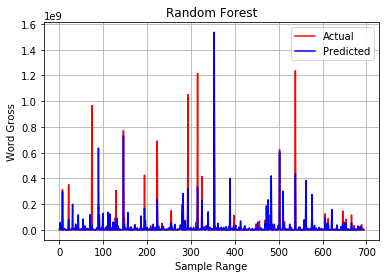

In [21]:
random_forest_model = RandomForestRegressor()
rsquare, mae, mse = run_model_with_plot("Random Forest", random_forest_model, X_train, X_test, y_train, y_test)

In [22]:
run_model_with_k_fold("Random Forest", random_forest_model, tokenized_data, atemp[predict_col], 4)

Random Forest with k fold
rsquare test mean:  0.5131340346040689
mae test mean:  15835465.611736106
mse test mean 3506708855850698.0


(0.5131340346040689, 15835465.611736106, 3506708855850698.0)

## Explore feature selection

Based on output, current setting for feature selection does not give us good result to help our model. We will no longer use feature selection. Maybe for future work

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

In [24]:
tokenized_data.shape

(23474, 44)

In [25]:
X_new = SelectKBest(chi2, k=2).fit_transform(tokenized_data, atemp[predict_col])

In [26]:
X_new.shape

(23474, 2)

In [27]:
run_model_with_k_fold("Random Forest", random_forest_model, X_new, atemp[predict_col], 4)

Random Forest with k fold
rsquare test mean:  0.06745101751750493
mae test mean:  23611812.01923579
mse test mean 6639992998317304.0


(0.06745101751750493, 23611812.01923579, 6639992998317304.0)

In [28]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
XV_new = sel.fit_transform(tokenized_data)
XV_new.shape

(23474, 14)

In [29]:
run_model_with_k_fold("Random Forest", random_forest_model, X_new, atemp[predict_col], 4)

Random Forest with k fold
rsquare test mean:  0.037330019955578164
mae test mean:  23679714.88821294
mse test mean 6878309924405728.0


(0.037330019955578164, 23679714.88821294, 6878309924405728.0)

#### After explore different items in string_cols and category_cols, still feels like gadwc should all in category. 
#### We can see table in the next section

C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


------model name:  Random Forest ------
R suqare:  0.48289855091891454
mean absolute error:  16421359.33461129
mean square error:  4837456158050739.0


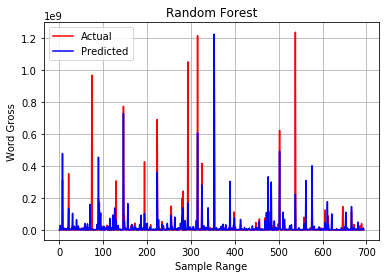

In [30]:
string_cols = ["primaryTitle"]
category_cols = ["genres", "actors","directors", "writers", "Country"]
num_cols = ["runtimeMinutes",  "director_sentiments","writer_sentiments", "director_sentiments_num", "writer_sentiments_num"]
predict_col = ["WorldGross"]
max_feature_num = 10
tokenized_data = process_tokenize_all_cols(atemp, 10)
X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, atemp[predict_col], max_feature_num)
random_forest_model = RandomForestRegressor()
rsquare, mae, mse = run_model_with_plot("Random Forest", random_forest_model, X_train, X_test, y_train, y_test)

## 10, 20, 30, 40, 50, 100 comparison for different category 

In [31]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [32]:
category = "A" #actor only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [33]:
category = "G" #genres only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [34]:
category = "C" #country only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [35]:
category = "D" #directors only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [36]:
category = "W" #writers only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [37]:
category = "WDC" #
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [38]:
category = "WDCG" #
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [39]:
category = "WDCAG" #
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [40]:
model_result

,model_names,categories,kfold,max_features,rsquare,mse,mae
0,Random_Forest,a,False,10,0.484452,4.822926e+15,1.787537e+07
1,Random_Forest,a,True,10,0.496015,3.630244e+15,1.652789e+07
2,Random_Forest,a,False,20,0.442553,5.214890e+15,1.801080e+07
3,Random_Forest,a,True,20,0.462987,3.857183e+15,1.669148e+07
4,Random_Forest,a,False,30,0.448535,5.158921e+15,1.780860e+07
5,Random_Forest,a,True,30,0.445318,3.993288e+15,1.675375e+07
6,Random_Forest,a,False,40,0.496397,4.711182e+15,1.745962e+07
7,Random_Forest,a,True,40,0.460256,3.898287e+15,1.658119e+07
8,Random_Forest,a,False,50,0.520818,4.482720e+15,1.689340e+07
9,Random_Forest,a,True,50,0.446725,3.985257e+15,1.641570e+07


In [41]:
kfold_random_forest= model_result[model_result['kfold']==True]

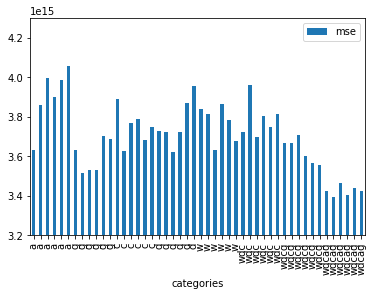

In [42]:
kfold_random_forest[['categories', 'mse']].plot(x='categories', y='mse',kind='bar',ylim=(3.2e15,4.3e15))

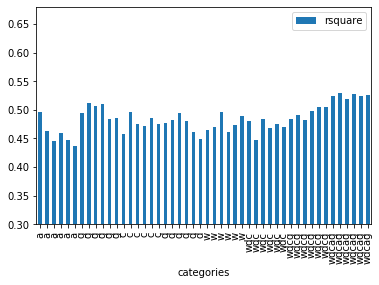

In [43]:
kfold_random_forest[['categories', 'rsquare']].plot(x='categories', y='rsquare',kind='bar',ylim=(0.3,0.68))

In [44]:
No_kfold_random_forest= model_result[model_result['kfold']==False]

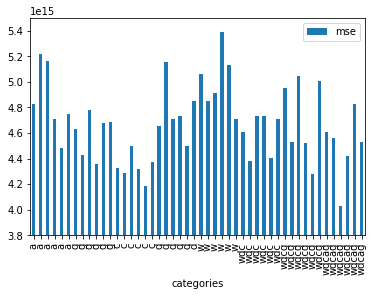

In [64]:
No_kfold_random_forest[['categories', 'mse']].plot(x='categories', y='mse',kind='bar',ylim=(3.8e15,5.5e15))

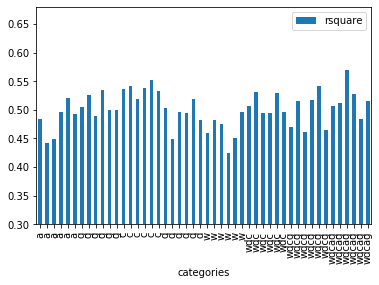

In [46]:
No_kfold_random_forest[['categories', 'rsquare']].plot(x='categories', y='rsquare',kind='bar',ylim=(0.3,0.68))

#### We can see that, with wdcag in category_cols, we get better result for both R and MSE with or without K fold.
#### Also, with feature = 30, we mostly got good tradeoff between R square and MSE. 

# K Nearest Neighbors

## set max_feature for each category = 30, k = 4

#### After a few tries, K Nearest Neighbors do not give good prediction. Move to next

In [47]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
category = "D" 
set_max_run_model_and_append_to_result( "K_Nearest_neighbors_ball_tree_5", category,
                                           KNeighborsRegressor(n_neighbors = 5, algorithm='ball_tree'),
                                           30, atemp, b_print=False)

In [49]:
category = "WDCG" #directors only
set_max_run_model_and_append_to_result( "K_Nearest_neighbors_ball_tree_5", category,
                                           KNeighborsRegressor(n_neighbors = 5, algorithm='ball_tree'),
                                           30, atemp,  b_print=False)

In [50]:
model_result

,model_names,categories,kfold,max_features,rsquare,mse,mae
0,Random_Forest,a,False,10,0.484452,4.822926e+15,1.787537e+07
1,Random_Forest,a,True,10,0.496015,3.630244e+15,1.652789e+07
2,Random_Forest,a,False,20,0.442553,5.214890e+15,1.801080e+07
3,Random_Forest,a,True,20,0.462987,3.857183e+15,1.669148e+07
4,Random_Forest,a,False,30,0.448535,5.158921e+15,1.780860e+07
5,Random_Forest,a,True,30,0.445318,3.993288e+15,1.675375e+07
6,Random_Forest,a,False,40,0.496397,4.711182e+15,1.745962e+07
7,Random_Forest,a,True,40,0.460256,3.898287e+15,1.658119e+07
8,Random_Forest,a,False,50,0.520818,4.482720e+15,1.689340e+07
9,Random_Forest,a,True,50,0.446725,3.985257e+15,1.641570e+07


# Decision Tree

In [51]:
from sklearn import tree

Now category has:  ['genres', 'Country', 'directors', 'writers', 'actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 151)
------model name:  Decision_tree ------
R suqare:  0.2387960319147603
mean absolute error:  18777955.364004258
mean square error:  7121022053777283.0


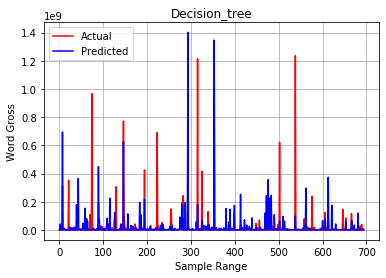

Decision_tree with k fold
rsquare test mean:  0.074029664794828
mae test mean:  18436836.112977274
mse test mean 6570375871643894.0


In [52]:
category = "WADCG" #directors only
set_max_run_model_and_append_to_result( "Decision_tree", category,
                                           tree.DecisionTreeRegressor(),
                                           30, atemp)

# AdaBoostRegression, GradientBoostingRegressor

In [53]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

Now category has:  ['genres', 'Country', 'directors', 'writers', 'actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 151)
------model name:  AdaBoost ------
R suqare:  -2.6465961728060075
mean absolute error:  174806420.8116966
mean square error:  3.411371045935427e+16


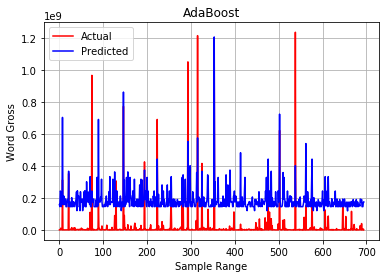

AdaBoost with k fold
rsquare test mean:  -5.8403605624902255
mae test mean:  207769189.9234344
mse test mean 4.813133586583638e+16


In [54]:
category = "WDCGA" #directors only
set_max_run_model_and_append_to_result( "AdaBoost", category,
                                           AdaBoostRegressor(),
                                           30, atemp)

Now category has:  ['genres', 'actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 64)
------model name:  Gradient_Boosting ------
R suqare:  0.5357829248551602
mean absolute error:  17049435.76197564
mean square error:  4342725693038186.5


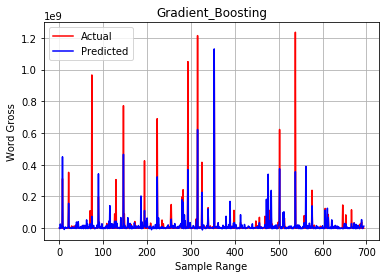

Gradient_Boosting with k fold
rsquare test mean:  0.551189526833042
mae test mean:  15978064.882155761
mse test mean 3242430724195339.0


In [55]:
category = "AG" #directors only
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp)

In [56]:
category = "G" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "W" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "C" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "D" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "WDCG" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "WDC" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "WDCGA" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)

In [57]:
model_result

,model_names,categories,kfold,max_features,rsquare,mse,mae
0,Random_Forest,a,False,10,0.484452,4.822926e+15,1.787537e+07
1,Random_Forest,a,True,10,0.496015,3.630244e+15,1.652789e+07
2,Random_Forest,a,False,20,0.442553,5.214890e+15,1.801080e+07
3,Random_Forest,a,True,20,0.462987,3.857183e+15,1.669148e+07
4,Random_Forest,a,False,30,0.448535,5.158921e+15,1.780860e+07
5,Random_Forest,a,True,30,0.445318,3.993288e+15,1.675375e+07
6,Random_Forest,a,False,40,0.496397,4.711182e+15,1.745962e+07
7,Random_Forest,a,True,40,0.460256,3.898287e+15,1.658119e+07
8,Random_Forest,a,False,50,0.520818,4.482720e+15,1.689340e+07
9,Random_Forest,a,True,50,0.446725,3.985257e+15,1.641570e+07


# Gaussian Process Regression, KernelRidge 

In [58]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge

#### GPR runs too slow

In [59]:
#kernel = WhiteKernel()


In [65]:
#category = "AG" #directors only
#set_max_run_model_and_append_to_result( "GPR", category, GaussianProcessRegressor(kernel=kernel,random_state=0),
#                                           30, atemp)

#### KernelRidge also slow

Now category has:  ['genres', 'actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 64)
------model name:  KernelRidge ------
R suqare:  0.37391643753391657
mean absolute error:  26134533.405537806
mean square error:  5856977949081291.0


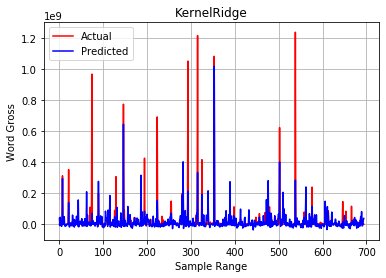

KernelRidge with k fold
rsquare test mean:  0.36061388167131014
mae test mean:  25401919.095796093
mse test mean 4607586902477713.0


In [66]:
category = "AG" #directors only
set_max_run_model_and_append_to_result( "KernelRidge", category,
                                          KernelRidge(alpha=1.0),
                                           30, atemp)

## Multi-layer Perceptron regressor

#### Fail to find good setting to run sklearn MLP model.

In [67]:
from sklearn.neural_network import MLPRegressor

In [68]:
regressor = MLPRegressor(hidden_layer_sizes = (40,20), activation = 'relu', solver = 'adam', learning_rate = 'adaptive')

Now category has:  ['genres', 'directors', 'writers']
True
for each category except genre, the max features are:  30
data shape:  (23474, 93)
------model name:  MLP ------
R suqare:  -0.003206635639403599
mean absolute error:  25132709.460708626
mean square error:  9384943952478102.0


C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


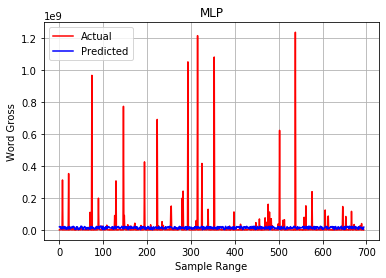

C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP with k fold
rsquare test mean:  -0.0043960832918536474
mae test mean:  24026748.007671174
mse test mean 7222959313759262.0


C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [69]:
category = "WDG" 
set_max_run_model_and_append_to_result( "MLP", category,
                                           regressor,
                                           30, atemp)


In [70]:
model_result

,model_names,categories,kfold,max_features,rsquare,mse,mae
0,Random_Forest,a,False,10,0.484452,4.822926e+15,1.787537e+07
1,Random_Forest,a,True,10,0.496015,3.630244e+15,1.652789e+07
2,Random_Forest,a,False,20,0.442553,5.214890e+15,1.801080e+07
3,Random_Forest,a,True,20,0.462987,3.857183e+15,1.669148e+07
4,Random_Forest,a,False,30,0.448535,5.158921e+15,1.780860e+07
5,Random_Forest,a,True,30,0.445318,3.993288e+15,1.675375e+07
6,Random_Forest,a,False,40,0.496397,4.711182e+15,1.745962e+07
7,Random_Forest,a,True,40,0.460256,3.898287e+15,1.658119e+07
8,Random_Forest,a,False,50,0.520818,4.482720e+15,1.689340e+07
9,Random_Forest,a,True,50,0.446725,3.985257e+15,1.641570e+07


In [71]:
model_result.to_csv('model_result.csv',  header = True, chunksize = 10)
print('finishing saving ...')

finishing saving ...
